# Prototyping network creator

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

Propotype a generator for fancy (non-random, developmentally-inspired) graphs

In [3]:
# Constants
n = 50
minCommunity = 3
tauCommunity = 1.2       # SOmething like an exponential constant for communities (except that they aren't random)
tauDegree = 1            # Exponential constant for degree distribution

degreePreference = 1     # Preferential attachment to high-degree nodes
internalPreference = 100 # Preferential attachment within communities, as opposed to between communities

In [4]:
# Map communities
commIndex = np.zeros(n)
iCommunity = 0                      # Community allocation
edgeLeft = 0                        # Left border of current community
thisSize = minCommunity             # Current community size
while edgeLeft<n:
    edgeRight = min(edgeLeft+thisSize,n) # Right border of current community
    commIndex[edgeLeft:edgeRight] = iCommunity
    iCommunity += 1
    edgeLeft += thisSize
    thisSize = int(np.ceil(thisSize*tauCommunity))

A **todo** sort of comment for the code below: right now it runs 0->n, performing degree-preferential assignment, which means that smaller (earlier) communities are more likely to be connected to. In the future, pick nodes in random order, that would be more fair.

To make communities connected, we still have to run 0->n though. Either we do it before random assignments, or after. In which case we'll ahve to reassign degrees. Probably before is better.

Also, just for the record: strictly speaking, connecting first element of next community to the last alament of the previous one doesn't guarantee graph connectedness. It woudl work in most practical cases though. Connecting a highest degree node from one community to a highest degree node from another community would be better, but it still doesn't guarantee connectedness. It is hard. Maybe a practical solution would be to test connectedness post-hoc, and just rerun the generator if the output is not in one piece.

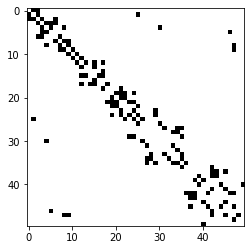

In [5]:
# Preferential attachment algorithm with communities

A = np.zeros((n,n))
deg = np.zeros(n,dtype=np.int8)    # Keep track of current degree, for preferential attachment later
A[0,1] = 1
A[1,0] = 1
deg[0] += 1
deg[1] += 1
for iNode in range(1,n):
    targetDegree = int(np.ceil(np.random.exponential(scale=tauDegree))) # Target degree for this cell
    if commIndex[iNode] != commIndex[iNode-1]: # New community started, link it to the previous one
        A[iNode,iNode-1] = 1
        A[iNode-1,iNode] = 1
        deg[iNode] = 1
        deg[iNode-1] = 0
        targetDegree += -1
    for iAttempt in range(targetDegree):
        prob = 1 + (commIndex==commIndex[iNode])*internalPreference + deg*degreePreference
        # Relative probability of attaching to every node
        prob[iNode] = 0                               # No self-connections
        prob[np.argwhere(A[iNode,:]>0)] = 0           # Don't try to reconnect if the connection is already there
        iNew = np.random.choice(n,1,p=prob/sum(prob)) # From <n options, take 1, according to probabilities p
        A[iNode,iNew] = 1
        A[iNew,iNode] = 1
        deg[iNode] += 1
        deg[iNew] += 1

plt.imshow(A, cmap="Greys")

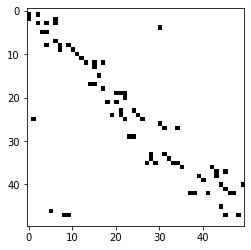

In [6]:
# Forest fire percolation asymmetrisator
# (For now based on direct matrix multiplication, as we can probably afford it)

flag = 1
fire = np.zeros(n,dtype=np.int8)
fire[int(np.floor(np.random.rand(1)*n))] = 1
coal = np.zeros(n,dtype=np.int8)
count = 0
B = np.copy(A)
while np.sum(coal)<n and count<1000:
    count += 1
    coal = np.minimum(1,coal+fire)               # Counting all nodes that were visited
    newfire = np.minimum(1,np.matmul(B,fire))    # Propagate fire
    burningEdges = np.minimum(1,np.matmul(np.diag(fire),B)) # Edges activated on this path
    burningEdges = burningEdges - burningEdges*np.transpose(burningEdges)*np.tril(np.ones(n)) 
    # (If both directions are activated, take the upper one)
    
    B = np.maximum(0,B-np.transpose(burningEdges)) # Remove edges running opposite to those that were activated
    fire = newfire
    if np.sum(fire)==0:
        fire[int(np.floor(np.random.rand(1)*n))] = 1 # If fire went out, reignite randomly    

plt.imshow(B, cmap="Greys")

C:\Users\khakh\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\khakh\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


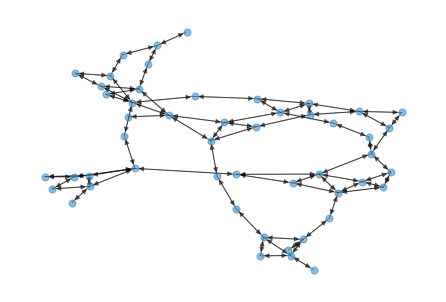

In [7]:
G = nx.DiGraph()
G = nx.from_numpy_matrix(A,create_using=G)
nx.draw_spring(G,node_size=50,alpha=0.5,iterations=100)

# For some reason draw_spring works really horribly with asymmetric graphs.
# Here's the original symmetic version:

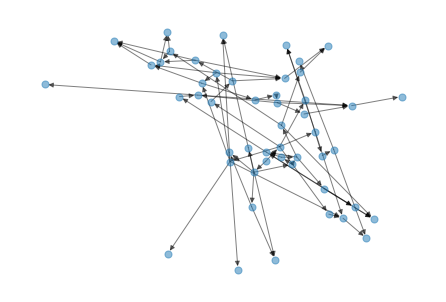

In [8]:
# And here's its asymmetric version. What's the heck?

G = nx.DiGraph()
G = nx.from_numpy_matrix(B,create_using=G)
nx.draw_spring(G,node_size=50,alpha=0.5,iterations=100)

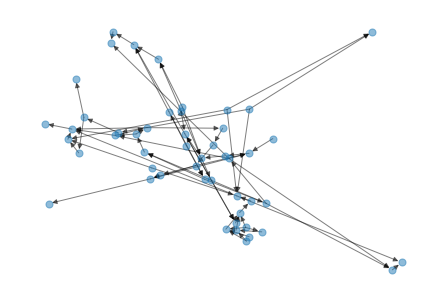

In [9]:
# As a test, let's see whether the layout problem is for all directed graphs,
# or only for my graph.
# The answer: the bug exists for all directed graphs.

G = nx.DiGraph()
G = nx.from_numpy_matrix(np.triu(A),create_using=G)
nx.draw_spring(G,node_size=50,alpha=0.5,iterations=100)

In [ ]:
# Built-in generator, except that it is symmetric, and has to be quite large
# For some reason doesn't work for n<250, and I cannot figure out how to make it work.
# Even for n=249 it just runs forever, while if I decrease min_community, it says that it fails community allocation.
def create_graph_variant():    
    A = nx.adjacency_matrix(nx.algorithms.community.community_generators.LFR_benchmark_graph(
        250, 3, 1.5, 0.1, min_degree=1, min_community=20, seed=10)).todense()
    
    #B = np.floor(np.random.rand(n,n)+0.5) # Random mask to de-symmetrize A
    #B = np.triu(B,k=1)
    #B = B + np.tril(1-np.transpose(B),k=-1)
    #A = np.multiply(A,B) # Pairwise multiplication
    
    edges = np.argwhere(A>0)
    
    return A